In [3]:
"""Generic Decrypt dataset handlers and everything else."""

import json
import re

from pathlib import Path

import numpy as np
from numpy.typing import ArrayLike
from PIL import Image
from torchvision import transforms as T
from typing import (
    AnyStr,
    Callable,
    Dict,
    List,
    NamedTuple,
    Optional,
    Tuple,
    Union
)

import torch
import torch.utils.data as D
from torch import TensorType

Coordinate = Tuple[int, int]


class GenericUnloadedSample(NamedTuple):
    """Represents a sample when the corresponding image is not loaded."""

    gt: ArrayLike
    og_len: int
    segm: ArrayLike
    filename: str


class GenericSample(NamedTuple):
    """Represents a sample after the image is loaded."""

    gt: ArrayLike
    og_len: int
    segm: ArrayLike
    filename: str

    img: TensorType
    curr_shape: Coordinate
    og_shape: Coordinate


class BatchedSample(NamedTuple):
    """Represents a batch of samples ready for inference."""

    gt: TensorType
    og_len: TensorType
    segm: TensorType
    filename: TensorType

    img: TensorType
    curr_shape: TensorType
    og_shape: TensorType


class GenericDecryptVocab:
    """Represents a vocabulary file."""

    blank = "<BLANK>"
    go_tok = "<GO>"
    stop_tok = "<STOP>"
    pad_tok = "<PAD>"

    def __init__(self, path: str) -> None:
        """Initialise the vocab object with the file pointed at the input path.

        :param path: Path to a vocab json file.
        """
        with open(path, "r") as f_labels:
            jlabels = json.load(f_labels)

        self.tokens = [self.blank, self.go_tok, self.stop_tok, self.pad_tok]
        self.vocab = self.tokens + jlabels["labels"]

        self.vocab2index = {
            x: ii for ii, x in enumerate(self.vocab)
        }
        self.index2vocab = {
            v: k for k, v in self.vocab2index.items()
        }

    def __len__(self):
        """Get the number of tokens in the vocabulary.

        :returns: Number of tokens in the vocab.
        """
        return len(self.vocab)

    def encode(self, labels: List[str]) -> List[int]:
        """Convert the input token sequence into a list of integers.

        :param labels: List of textual labels for a Decrypt transcript.
        :returns: List of integers representing the input sequence.
        """
        return [self.vocab2index[x] for x in labels]

    def decode(self, encoded: List[int]) -> List[str]:
        """Convert the input token sequence back to a list of textual tokens.

        :param labels: List of indices for a Decrypt transcript.
        :returns: List of tokens for the underlying sequence.
        """
        return [self.index2vocab[x] for x in encoded]

    def pad(self, encoded: List[int], pad_len: int, go: bool = False) -> List[int]:
        """Pad input sequence to a fixed width using special tokens.

        :param labels: List of indices for a Decrypt transcript.
        :param pad_len: Expected length of the output sequence.
        :param go: Whether to insert go and end tokens in the transcript.
        :returns: List of indices with a go and an end token at the beginning
        and the end of the sequence plus padding tokens to match the max
        sequence length provided as argument.
        """
        assert len(encoded) + 2 <= pad_len
        if go:
            return [self.vocab2index[self.go_tok]] \
                + encoded \
                + [self.vocab2index[self.stop_tok]] \
                + [self.vocab2index[self.pad_tok]
                   for _ in range(pad_len - len(encoded) - 2)]
        else:
            return encoded + (
                [self.vocab2index[self.pad_tok]] * (pad_len - len(encoded))
            )

    def unpad(self, padded: List[int]) -> List[int]:
        """Perform the inverse operation to the pad function.

        :param padded: List containing a padded sequence of indices.
        :returns: The same input sequence with padding and extra go/end tokens
        removed.
        """
        output = []
        for x in padded:
            if x == self.vocab2index[self.stop_tok]:
                break
            if x == self.vocab2index[self.pad_tok] or \
                    x == self.vocab2index[self.go_tok]:
                continue
            output.append(x)
        return output

    def prepare_data(self, data_in: List[str], pad_len: int) -> ArrayLike:
        """Perform encoding, padding and conversion to array.

        :param data_in: Input sequence in token format.
        :param pad_len: Length to pad the input sequence to.
        :returns: The input sequence with padding in array form.
        """
        data = self.pad(self.encode(data_in), pad_len)
        data = np.array(data)

        return data


class GenericDecryptDataset(D.Dataset):
    """Performs loading and management of Decrypt-formatted datasets."""

    DEFAULT_TRANSFORMS = T.Compose([
        T.ToTensor(),
        T.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    RE_SEPARATOR = re.compile(" ")

    def __init__(
            self,
            image_folder: str,
            dataset_file: str,
            vocab: GenericDecryptVocab,
            seqlen: int,
            target_shape: Coordinate,
            aug_pipeline: Optional[List[Callable]] = None,
    ) -> None:
        """Initialise Dataset object.

        :param image_folder: Path where the images of the dataset are stored.
        :param dataset_file: Path to the json file of the dataset.
        :param vocab: Decrypt vocabulary object to perform encoding/decoding.
        :param seqlen: Sequence length to pad the transcripts to.
        :param target_shape: Desired image size as a (width, height) tuple.
        :param aug_pipeline: List of augmentations to perform on the loaded
        Tensor-format image. Resizing, conversion to tensor and normalisation
        are handled by default.
        """
        super(GenericDecryptDataset).__init__()

        self._samples = []
        self._image_folder = Path(image_folder)  # Images Folder
        self._dataset_file = Path(dataset_file)  # GT File
        self._seqlen = seqlen
        self._target_shape = target_shape
        aug_pipeline = aug_pipeline or []
        self._aug_pipeline = T.Compose([*aug_pipeline, self.DEFAULT_TRANSFORMS])

        with open(self._dataset_file, "r") as f_gt:
            gt = json.load(f_gt)

        for fn, sample in gt.items():
            transcript = self.RE_SEPARATOR.split(sample["ts"])
            segmentation = [[-1.0, -1.0]] + sample["segm"] + \
                ([[-1.0, -1.0]] * (self._seqlen - len(sample["segm"]) - 1))
            segmentation = np.array(segmentation)

            og_len = len(transcript)
            transcript = vocab.prepare_data(transcript, self._seqlen)

            self._samples.append(GenericUnloadedSample(
                gt=transcript,
                og_len=og_len,
                segm=segmentation,
                filename=str(self._image_folder / fn),
            ))

    def __len__(self) -> int:
        """Get the number of samples in the dataset.

        :returns: Integer with the number of samples in the dataset.
        """
        return len(self._samples)

    def __getitem__(self, index: int) -> GenericSample:
        """Retrieve a single sample from the dataset as indexed.

        :param index: The index of the sample to retrieve.
        """
        sample = self._samples[index]

        img = Image.open(sample.filename).convert('RGB')

        og_shape = img.size
        img_width, img_height = og_shape
        tgt_width, tgt_height = self._target_shape

        factor = min(tgt_width / img_width, tgt_height / img_height)
        new_shape = tuple(map(lambda x: int(x * factor), og_shape))

        img = img.resize(new_shape)
        padded_img = Image.new(img.mode, self._target_shape, (255, 255, 255))
        padded_img.paste(img, (0, 0))

        padded_img = self._aug_pipeline(padded_img)

        normalised_coords = (sample.segm * factor) / tgt_width

        return GenericSample(
            sample.gt,
            sample.og_len,
            normalised_coords,
            sample.filename,
            padded_img,
            new_shape,
            og_shape,
        )

In [4]:
import matplotlib.pyplot as plt

def plotimg(img):
    plt.figure()
    plt.imshow(img)
    plt.show()
    plt.close()

In [12]:
augmentations = {
    1: [
        T.GaussianBlur(3),
        T.RandomEqualize(),
        T.RandomPerspective(),
    ]
}


In [45]:
vocab = GenericDecryptVocab(
    "/home/ptorras/Documents/Datasets/decrypt_cleanup/vatican/vocab.json"
)

dataset = GenericDecryptDataset(
    "/home/ptorras/Documents/Datasets/decrypt_cleanup/vatican/words",
    "/home/ptorras/Documents/Datasets/decrypt_cleanup/vatican/gt_words_training.json",
    vocab,
    130,
    (512, 64),
    augmentations[1],
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


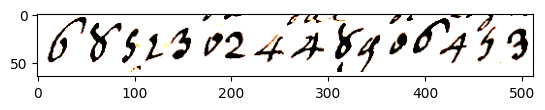

In [51]:
%time

plotimg(np.transpose(dataset[0].img, axes=(1,2,0)))